In [48]:
%load_ext autoreload
import pickle
import sys
sys.path.append('../../..')
import numpy as np
from scipy.interpolate import interp1d
import scipy.sparse as sp
from tqdm import tqdm_notebook as tqdm

import main
import darkhistory.physics as phys
import darkhistory.low_energy.atomic as atomic
import darkhistory.low_energy.bound_free as bf
from darkhistory.spec.spectools import discretize, get_bin_bound

import matplotlib
matplotlib.rc_file('../../../matplotlibrc')
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.colors as colors
%matplotlib inline

hplanck = phys.hbar * 2*np.pi

output_dir = '/Users/viviesque/OneDrive - Massachusetts Institute of Technology/DarkHistory/output/'
fig_dir = '/Users/viviesque/OneDrive - Massachusetts Institute of Technology/DarkHistory/figs/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# MLA vs TLA comparison

In [49]:
%autoreload

nmax=100
dlnz = .001 * 16
rs_vec  = np.exp(np.arange(np.log(10),np.log(3e3),dlnz))
length = len(rs_vec)
skip = 1 # number of redshift steps to skip at a time
Tr_vec, Tm_vec  = phys.TCMB(rs_vec), phys.Tm_std(rs_vec)
xe_vec, x1s_vec  = phys.x_std(rs_vec, 'HII'), phys.x_std(rs_vec, 'HI')
nH_vec  = phys.nH * rs_vec**3

def g_nl(l): return 2*l +1
def E(n): return phys.rydberg/n**2

tau_vec = atomic.tau_np_1s(2,rs_vec)
x2s_vec = atomic.x2s_steady_state(rs_vec, Tr_vec, Tm_vec, xe_vec, x1s_vec, tau_vec)
x2_vec  = 4*x2s_vec
eng = np.exp(np.linspace(np.log(hplanck*1e8), np.log(phys.rydberg), 500))
num_states = int(nmax*(nmax+1)/2)
ident = np.identity(num_states-1)
R, Thetas = atomic.populate_radial(nmax), bf.populate_thetas(nmax)

states_n = np.concatenate([list(map(int,k*np.ones(k))) for k in range(1,nmax+1,1)])
states_l = np.concatenate([np.arange(k) for k in range(1,nmax+1)])

x_vec = np.zeros((length,num_states-1))
# x_lte = np.zeros(num_states) #equilibrium solution

for i in tqdm(np.arange(0,length,skip)):
    rs = rs_vec[i]
    xe, x1s, x2s, nH  = xe_vec[i], x1s_vec[i], x2s_vec[i], nH_vec[i]
    Tr, Tm = Tr_vec[i], Tm_vec[i]

    #Get the transition rates
    BB, BB_2s1s = atomic.populate_bound_bound(nmax, Tr, R, Delta_f=None)
    alpha = atomic.populate_alpha(Tm, Tr, nmax, Delta_f=None,
                                  stimulated_emission=True, Thetas=Thetas)
    beta = atomic.populate_beta(Tr, nmax, Delta_f=None, Thetas=Thetas)

    #Include sobolev optical depth
    for n in range(2,nmax+1):
        BB['dn'][n][1][1] *= atomic.p_np_1s(n, rs, xHI=x1s)
        BB['up'][1][n][0] *= atomic.p_np_1s(n, rs, xHI=x1s)

    ### Build matrix K_ij = R_ji/R_i,tot and inhomogeneous term ###
    K = np.zeros((num_states, num_states))
    b = np.zeros(num_states)
    for nl in np.arange(num_states):
        # Find indices for possible states to transition to (l must change by 1)
        # Get the rates for transitioning to those states, as well as total rate

        n = states_n[nl]
        l = states_l[nl]
        # x_lte[nl] = g_nl(l) * np.exp((E(n)-E(1))/Tr) * x2s
        tot_rate = np.sum(BB['dn'][n,:,l]) + np.sum(BB['up'][n,:,l]) + beta[n][l]
        
        if nl == 0:  # special case: 1s -> 2s
            tot_rate += BB_2s1s['up']
            if tot_rate > 0:
                K[0][1] = BB_2s1s['up'] / tot_rate
        if nl == 1:  # special case: 2s -> 1s
            tot_rate += BB_2s1s['dn']
            K[1][0] = BB_2s1s['dn'] / tot_rate
        if l != 0:
            K[nl, states_l == l-1] = BB['up'][l:, n, l-1]/tot_rate
        if l != nmax-1:
            if tot_rate > 0:
                K[nl, states_l == l+1] = BB['dn'][l+2:, n, l+1]/tot_rate

        # Construct the inhomogeneous term
        b[nl] += xe**2 * nH * alpha[n][l]
        if l==1:
            b[nl] += x1s*BB['up'][1, n, 0]
        elif nl==1:
            # 1s to 2s transition from detailed balance
            b[nl] += x1s*BB['dn'][2][1][0]*np.exp(-phys.lya_eng/Tr)
            
        b[nl] /= tot_rate

    #Probability matrix for only the excited states
#     M = ident - K[1:,1:]  # omit the 1s state (zeroth index)
#     x_vec[i] = np.linalg.solve(M,b[1:])
    M = sp.csr_matrix(ident - K[1:,1:])
    x_vec[i] = sp.linalg.spsolve(M, b[1:])

../../../darkhistory/low_energy/atomic.py:353: RuntimeWarning: invalid value encountered in less
  emission_mask[Ennp_mat < 0] *= 0.
../../../darkhistory/low_energy/atomic.py:356: RuntimeWarning: invalid value encountered in greater
  absorption_mask[Ennp_mat > 0] *= 0.
../../../darkhistory/low_energy/atomic.py:359: RuntimeWarning: invalid value encountered in less_equal
  non_pos_mask[(Ennp_mat <= 0) | (np.isnan(Ennp_mat))] = 1.
/Users/viviesque/opt/anaconda3/envs/DarkHistoryEnvironment/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars
/Users/viviesque/opt/anaconda3/envs/DarkHistoryEnvironment/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: overflow encountered in true_divide


/Users/viviesque/opt/anaconda3/envs/DarkHistoryEnvironment/lib/python3.7/site-packages/matplotlib/axes/_base.py:3507: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  self.set_ylim(upper, lower, auto=None)


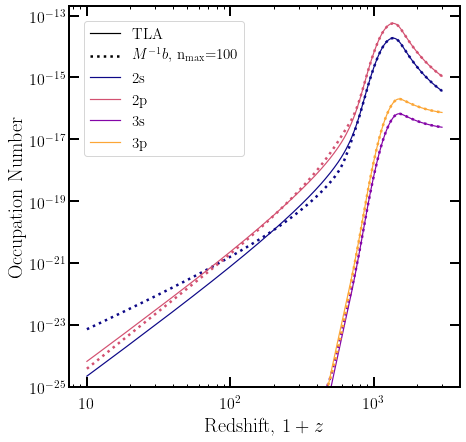

In [50]:
cmap = cm.plasma(np.linspace(0.,.8,4))
lw=1.2  # linewidth

plt.figure(figsize=(7,7))
plt.loglog()

plt.plot(rs_vec, np.ones_like(rs_vec), label=r'TLA', color='k', linewidth=lw)
plt.plot(rs_vec, np.ones_like(rs_vec), label=r'$M^{-1} b$, $\mathrm{n_{max}}$='+str(nmax), color='k', linestyle=':')

plt.plot(rs_vec, x2s_vec, label='2s', color=cmap[0], linewidth=lw)
plt.plot(rs_vec[::skip], x_vec[:,0], color=cmap[0], linestyle=':')

plt.plot(rs_vec, 3*x2s_vec, label='2p', color=cmap[2], linewidth=lw)
plt.plot(rs_vec[::skip], x_vec[:,1], color=cmap[2], linestyle=':')

plt.plot(rs_vec, g_nl(0)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), 
         label='3s', color=cmap[1], linewidth=lw)
plt.plot(rs_vec[::skip], x_vec[:,2], color=cmap[1], linestyle=':')

plt.plot(rs_vec, g_nl(1)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), 
         label='3p', color=cmap[3], linewidth=lw)
plt.plot(rs_vec[::skip], x_vec[:,3], color=cmap[3], linestyle=':')

plt.ylim([1e-25,2e-13])
plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Occupation Number', fontsize=20)
plt.legend(fontsize=15)

#plt.savefig(fig_dir+'MLA_vs_TLA.pdf')

# Evolution in the presence of energy injection

In [51]:
# Load example data
results_comp = pickle.load(open(output_dir+f'component_distortions.p','rb'))

In [58]:
rs_vec = results_comp['MLA'][0]
alpha_MLA_vec = results_comp['MLA'][1]
beta_MLA_vec = results_comp['MLA'][2]
beta_DM_vec = results_comp['MLA'][3]

(4, 415)

In [56]:
%autoreload

nmax=100
rs_vec  = results_comp['rs']
length = len(rs_vec)
skip = 1 # number of redshift steps to skip at a time
Tr_vec, Tm_vec  = phys.TCMB(rs_vec), results_comp['Tm']
xe_vec, x1s_vec  = results_comp['x'][:,0]+results_comp['x'][:,1], 1-results_comp['x'][:,0]
nH_vec  = phys.nH * rs_vec**3

R, Thetas = atomic.populate_radial(nmax), bf.populate_thetas(nmax)
num_states = int(nmax*(nmax+1)/2)
ident = np.identity(num_states-1)

states_n = np.concatenate([list(map(int,k*np.ones(k))) for k in range(1,nmax+1,1)])
states_l = np.concatenate([np.arange(k) for k in range(1,nmax+1)])

x_vec = np.zeros((length,num_states-1))
wts = np.zeros(length)

for i, rs in enumerate(tqdm(rs_vec)):
    xe, x1s, nH = xe_vec[i], x1s_vec[i], nH_vec[i]
    Tr, Tm = Tr_vec[i], Tm_vec[i]
    
    # Calculate phase space of distortion
    temp_dist = results_comp['distortions'].copy()
    temp_dist.redshift(rs)
    wts[i] = 1
    distortion = temp_dist.sum_specs(weight=wts)
    
    dist_mask = np.ones_like(distortion.eng)
    bnds = get_bin_bound(distortion.eng)
    E_1n = phys.rydberg * (1 - 1/np.arange(2, nmax)**2)
    for E in E_1n:
        ind = (sum(bnds <= E)-1)
        dist_mask[ind] = 0
    dist_mask *= distortion.eng < phys.rydberg  # keep E<13.6eV photons
    
    prefac = phys.nB * (phys.hbar*phys.c*rs)**3 * np.pi**2
    Delta_f = interp1d(
        distortion.eng, prefac*distortion.dNdE/distortion.eng**2*dist_mask,
        bounds_error=False, fill_value=(0, 0), kind='nearest'
    )
    
    ### FIX THIS FUNCTION AND ADD IT IN
    # Calculate contribution from excitations
    
    delta_b = atomic.f_exc_to_b_numerator(
        deposited_exc_arr,
        tot_spec_elec, streaming_lowengphot,
        H_states, dt, rate_func_eng,
        nmax, x_1s
    )

    #Get the transition rates
    BB, BB_2s1s = atomic.populate_bound_bound(nmax, Tr, R, Delta_f=Delta_f)
    alpha = atomic.populate_alpha(Tm, Tr, nmax, Delta_f=Delta_f,
                                  stimulated_emission=True, Thetas=Thetas)
    beta = atomic.populate_beta(Tr, nmax, Delta_f=Delta_f, Thetas=Thetas)

    #Include sobolev optical depth
    for n in range(2,nmax+1):
        BB['dn'][n][1][1] *= atomic.p_np_1s(n, rs, xHI=x1s)
        BB['up'][1][n][0] *= atomic.p_np_1s(n, rs, xHI=x1s)

    ### Build matrix K_ij = R_ji/R_i,tot and inhomogeneous term ###
    K = np.zeros((num_states, num_states))
    b = np.zeros(num_states)
    for nl in np.arange(num_states):
        # Find indices for possible states to transition to (l must change by 1)
        # Get the rates for transitioning to those states, as well as total rate

        n = states_n[nl]
        l = states_l[nl]
        tot_rate = np.sum(BB['dn'][n,:,l]) + np.sum(BB['up'][n,:,l]) + beta[n][l]
        
        if nl == 0:  # special case: 1s -> 2s
            tot_rate += BB_2s1s['up']
            if tot_rate > 0:
                K[0][1] = BB_2s1s['up'] / tot_rate
        if nl == 1:  # special case: 2s -> 1s
            tot_rate += BB_2s1s['dn']
            K[1][0] = BB_2s1s['dn'] / tot_rate
        if l != 0:
            K[nl, states_l == l-1] = BB['up'][l:, n, l-1]/tot_rate
        if l != nmax-1:
            if tot_rate > 0:
                K[nl, states_l == l+1] = BB['dn'][l+2:, n, l+1]/tot_rate

        # Construct the inhomogeneous term
        b[nl] += xe**2 * nH * alpha[n][l]
        if l==1:
            b[nl] += x1s*BB['up'][1, n, 0]
        elif nl==1:
            # 1s to 2s transition from detailed balance
            b[nl] += x1s*BB_2s1s['up']
        b[nl] += delta_b.get(spec_ind, 0)
        b[nl] /= tot_rate

    #Probability matrix for only the excited states
    M = sp.csr_matrix(ident - K[1:,1:])
    x_vec[i] = sp.linalg.spsolve(M, b[1:])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

[1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

KeyboardInterrupt: 

In [ ]:
cmap = cm.plasma(np.linspace(0.,.8,4))
lw=1.2  # linewidth

plt.figure(figsize=(7,7))
plt.loglog()

plt.plot(rs_vec, np.ones_like(rs_vec), label=r'TLA', color='k', linewidth=lw)
plt.plot(rs_vec, np.ones_like(rs_vec), label=r'$M^{-1} b$, $\mathrm{n_{max}}$='+str(nmax), color='k', linestyle=':')

plt.plot(rs_vec, x2s_vec, label='2s', color=cmap[0], linewidth=lw)
plt.plot(rs_vec[::skip], x_vec[:,0], color=cmap[0], linestyle=':')

plt.plot(rs_vec, 3*x2s_vec, label='2p', color=cmap[2], linewidth=lw)
plt.plot(rs_vec[::skip], x_vec[:,1], color=cmap[2], linestyle=':')

plt.plot(rs_vec, g_nl(0)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), 
         label='3s', color=cmap[1], linewidth=lw)
plt.plot(rs_vec[::skip], x_vec[:,2], color=cmap[1], linestyle=':')

plt.plot(rs_vec, g_nl(1)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), 
         label='3p', color=cmap[3], linewidth=lw)
plt.plot(rs_vec[::skip], x_vec[:,3], color=cmap[3], linestyle=':')

plt.ylim([1e-25,2e-13])
plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Occupation Number', fontsize=20)
plt.legend(fontsize=15)

#plt.savefig(fig_dir+'MLA_pops.pdf')